In [1]:
import sympy
from filterpy.kalman import ExtendedKalmanFilter as EKF
from numpy import array, sqrt
from sympy.abc import alpha, x, y, v, w, R, theta
from sympy import symbols, Matrix
import numpy as np
from math import sqrt, tan, cos, sin, atan2


class RobotEKF(EKF):
    def __init__(self, dt, wheelbase, std_vel, std_steer):
        EKF.__init__(self, 3, 2, 2)
        self.dt = dt
        self.wheelbase = wheelbase
        self.std_vel = std_vel
        self.std_steer = std_steer
        a, x, y, v, w, theta, time = symbols(
        'a, x, y, v, w, theta, t')
        d = v*time
        beta = (d/w)*sympy.tan(a)
        r = w/sympy.tan(a)
        self.fxu = Matrix(
        [[x-r*sympy.sin(theta)+r*sympy.sin(theta+beta)],
        [y+r*sympy.cos(theta)-r*sympy.cos(theta+beta)],
        [theta+beta]])
        self.F_j = self.fxu.jacobian(Matrix([x, y, theta]))
        self.V_j = self.fxu.jacobian(Matrix([v, a]))
        # save dictionary and it's variables for later use
        self.subs = {x: 0, y: 0, v:0, a:0,
        time:dt, w:wheelbase, theta:0}
        self.x_x, self.x_y, = x, y
        self.v, self.a, self.theta = v, a, theta


    def predict(self, u):
        self.x = self.move(self.x, u, self.dt)
        self.subs[self.theta] = self.x[2, 0]
        self.subs[self.v] = u[0]
        self.subs[self.a] = u[1]
        F = array(self.F_j.evalf(subs=self.subs)).astype(float)
        V = array(self.V_j.evalf(subs=self.subs)).astype(float)
        # covariance of motion noise in control space
        M = array([[self.std_vel*u[0]**2, 0],
        [0, self.std_steer**2]])
        self.P = np.dot(F, self.P).dot(F.T) + np.dot(V, M).dot(V.T)


    def move(self, x, u, dt):
        hdg = x[2, 0]
        vel = u[0]
        steering_angle = u[1]
        dist = vel * dt
        if abs(steering_angle) > 0.001: # is robot turning?
            beta = (dist / self.wheelbase) * tan(steering_angle)
            r = self.wheelbase / tan(steering_angle) # radius
            dx = np.array([[-r*sin(hdg) + r*sin(hdg + beta)],
            [r*cos(hdg) - r*cos(hdg + beta)],
            [beta]])
        else: # moving in straight line
            dx = np.array([[dist*cos(hdg)],
            [dist*sin(hdg)],
            [0]])
        return x + dx

In [5]:
from math import sqrt
def H_of(x, landmark_pos):
    """ compute Jacobian of H matrix where h(x) computes
    the range and bearing to a landmark for state x """
    px = landmark_pos[0]
    py = landmark_pos[1]
    hyp = (px - x[0, 0])**2 + (py - x[1, 0])**2
    dist = sqrt(hyp)
    H = array(
    [[-(px - x[0, 0]) / dist, -(py - x[1, 0]) / dist, 0],
    [ (py - x[1, 0]) / hyp, -(px - x[0, 0]) / hyp, -1]])
    return H

In [6]:
from math import atan2
def Hx(x, landmark_pos):
    """ takes a state variable and returns the measurement
    that would correspond to that state.
    """
    px = landmark_pos[0]
    py = landmark_pos[1]
    dist = sqrt((px - x[0, 0])**2 + (py - x[1, 0])**2)
    Hx = array([[dist],
    [atan2(py - x[1, 0], px - x[0, 0]) - x[2, 0]]])
    return Hx

In [2]:
def residual(a, b):
    """ compute residual (a-b) between measurements containing
    [range, bearing]. Bearing is normalized to [-pi, pi)"""
    y = a - b
    y[1] = y[1] % (2 * np.pi) # force in range [0, 2 pi)
    if y[1] > np.pi: # move to [-pi, pi)
        y[1] -= 2 * np.pi
    return y

In [3]:
from numpy.random import randn
from filterpy.stats import plot_covariance_ellipse
from math import sqrt, tan, cos, sin, atan2
import matplotlib.pyplot as plt
dt = 1.0
def z_landmark(lmark, sim_pos, std_rng, std_brg):
    x, y = sim_pos[0, 0], sim_pos[1, 0]
    d = np.sqrt((lmark[0] - x)**2 + (lmark[1] - y)**2)
    a = atan2(lmark[1] - y, lmark[0] - x) - sim_pos[2, 0]
    z = np.array([[d + randn()*std_rng],
    [a + randn()*std_brg]])
    return z

def ekf_update(ekf, z, landmark):
    ekf.update(z, HJacobian=H_of, Hx=Hx,
    residual=residual,
    args=(landmark), hx_args=(landmark))

def run_localization(landmarks, std_vel, std_steer,
                    std_range, std_bearing,
                    step=10, ellipse_step=20, ylim=None):
    ekf = RobotEKF(dt, wheelbase=0.5, std_vel=std_vel,
        std_steer=std_steer)
    ekf.x = array([[2, 6, .3]]).T # x, y, steer angle
    ekf.P = np.diag([.1, .1, .1])
    ekf.R = np.diag([std_range**2, std_bearing**2])

    sim_pos = ekf.x.copy() # simulated position
    # steering command (vel, steering angle radians)
    u = array([1.1, .01])

    plt.figure()
    plt.scatter(landmarks[:, 0], landmarks[:, 1],
    marker='s', s=60)
    track = []

    for i in range(200):
        sim_pos = ekf.move(sim_pos, u, dt/10.) # simulate robot
        track.append(sim_pos)

        if i % step == 0:
            ekf.predict(u=u)

        if i % ellipse_step == 0:
            plot_covariance_ellipse(
                (ekf.x[0,0], ekf.x[1,0]), ekf.P[0:2, 0:2],
                std=6, facecolor='k', alpha=0.3)

            x, y = sim_pos[0, 0], sim_pos[1, 0]
        for lmark in landmarks:
            z = z_landmark(lmark, sim_pos,
                std_range, std_bearing)
            ekf_update(ekf, z, lmark)

        if i % ellipse_step == 0:
            plot_covariance_ellipse(
            (ekf.x[0,0], ekf.x[1,0]), ekf.P[0:2, 0:2],
            std=6, facecolor='g', alpha=0.8)

    track = np.array(track)
    plt.plot(track[:, 0], track[:,1], color='k', lw=2)
    plt.axis('equal')
    plt.title("EKF Robot localization")
    if ylim is not None: plt.ylim(*ylim)
    plt.show()
    return ekf

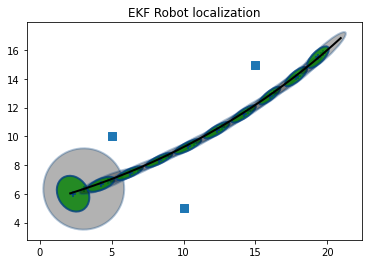

Final P: [0.00278955 0.00482978 0.00035695]


In [7]:
landmarks = array([[5, 10], [10, 5], [15, 15]])
ekf = run_localization(
    landmarks, std_vel=0.1, std_steer=np.radians(1),
    std_range=0.3, std_bearing=0.1)
print('Final P:', ekf.P.diagonal())